In [1]:
import re
import collections
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk

from collections import Counter

In [2]:
df = pd.read_csv('../datasets/raw/2020_06_23_CE-BVerwG_DE_Datensatz.csv')

In [3]:
minidf = df.sample(frac = 0.05)
minidf['text_normalized'] = minidf['text'].str.lower().str.replace("\n", " ").replace('\s+', ' ', regex=True)

In [4]:
vocab = nltk.lm.Vocabulary(minidf['text_normalized'], unk_cutoff=10)
data = []
for judgement in minidf['text_normalized']:
    data.extend(judgement.split(" "))
filtered_data = [word for word in data if len(word) > 1 or not word.isalpha()]


In [5]:
min_len = 10
max_len = 16

In [6]:
longgrams = list(nltk.everygrams(filtered_data, min_len=min_len, max_len=max_len-1))

In [16]:
most_common = Counter(longgrams)

In [17]:
most_common = most_common.most_common(2000)

In [18]:
phrases = []
frequencies_per_ngramlength = {i:[] for i in range(min_len, max_len)}
for phrase, frequency in most_common:
    if frequency < 5: # stop evaluating if the first ngram has less than x occurences
        break
    frequencies_per_ngramlength[len(phrase)].append((frequency, phrase))

frequencies = []
lengths = []
length_keys = list(frequencies_per_ngramlength.keys())
for length in length_keys[::-1]:
    counter = 0
    for frequency, phrase_candidate in frequencies_per_ngramlength[length]:
        pad_dist = length//3
        cut_phrase_candidate = " ".join(phrase_candidate[pad_dist:-pad_dist])
        phrase_candidate = " ".join(phrase_candidate)

        if not any([cut_phrase_candidate in phrase for phrase in phrases]):
            lengths.append(length)
            frequencies.append(frequency)
            phrases.append(phrase_candidate)
            counter += 1
            if counter > 5: # we only check the top 5 phrases at the given n
                break
        

In [19]:
for i in range(len(phrases)):
    print("freq: ", frequencies[i], "length", lengths[i])
    print(phrases[i])
    print("")

freq:  79 length 15
kläger trägt die kosten des beschwerdeverfahrens. der wert des streitgegenstandes wird für das beschwerdeverfahren auf

freq:  76 length 15
revision ist innerhalb eines monats nach zustellung dieses beschlusses zu begründen. die begründung ist bei

freq:  75 length 15
zustellung dieses beschlusses zu begründen. die begründung ist bei dem bundesverwaltungsgericht, simsonplatz 1, 04107 leipzig,

freq:  65 length 15
die revision wird zugelassen. die entscheidung über die kosten des beschwerdeverfahrens folgt der kostenentscheidung in

freq:  62 length 15
der einlegung einer revision durch den beschwerdeführer bedarf es nicht. die revision ist innerhalb eines

freq:  60 length 15
begründung ist bei dem bundesverwaltungsgericht, simsonplatz 1, 04107 leipzig, schriftlich oder in elektronischer form (verordnung

freq:  71 length 14
beschlossen: die beschwerde des klägers gegen die nichtzulassung der revision in dem urteil des

freq:  63 length 14
beschwerdeführer bedarf es

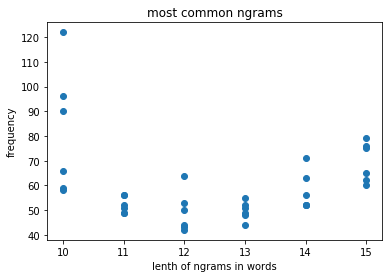

In [20]:
plt.title("most common ngrams")
plt.ylabel("frequency")
plt.xlabel("lenth of ngrams in words")
plt.scatter(lengths, frequencies)
plt.show()

In [ ]:
plt.title("anzahl dokumente nach verfahrensart für top 6 verfahrensarten. ")
subset = df.groupby(['Verfahrensart', 'Entscheidungsart']).size()
subset[subset > 200].sort_values().plot(kind='bar')
plt.show()
count = minidf['text'].str.split(" ").apply(len).sort_values()
plt.xscale("log")
count.plot.hist(bins=100)
plt.show()

In [11]:
import spacy #load spacy
nlp = spacy.load("de_core_news_sm", disable=['parser', 'tagger', 'ner'])
#stopwords = stopwords.words("german")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


In [29]:
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType,StructField, StringType

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()


In [31]:
from pyspark.ml.fpm import PrefixSpan
from pyspark import SparkContext

sc = SparkContext.getOrCreate();
plist = minidf['text_normalized'].tolist()
rdd = sc.parallelize(plist)
#df = spark.createDataFrame(rdd)

In [32]:
prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=20,
                        maxLocalProjDBSize=3200000)

# Find frequent sequential patterns.
prefixSpan.findFrequentSequentialPatterns(rdd).show()

AttributeError: 'RDD' object has no attribute '_jdf'

In [35]:
from pyspark.ml.fpm import PrefixSpan

df = sc.parallelize([Row(sequence=[[1, 2], [3]]),
                     Row(sequence=[[1], [3, 2], [1, 2]]),
                     Row(sequence=[[1, 2], [5]]),
                     Row(sequence=[[6]])]).toDF()

prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=5)

# Find frequent sequential patterns.
prefixSpan.findFrequentSequentialPatterns(df).show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3.0 (TID 3, 192.168.2.122, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/zastrow-marcks/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 477, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2139)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2120)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2139)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:154)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/zastrow-marcks/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 477, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2139)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
